<a href="https://colab.research.google.com/github/andoanminhkhanh/trituenhantao/blob/main/CNN_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Khai báo thư viện**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AveragePooling2D
from keras.applications import ResNet50
from tensorflow.keras.layers import Flatten,Dense,Dropout
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

In [3]:
from imutils import paths
imgTrain = list(paths.list_images("/content/drive/MyDrive/AI FINAL/train"))
imgTest = list(paths.list_images("/content/drive/MyDrive/AI FINAL/val"))

##**Tiền xử lý dữ liệu**

In [4]:
X_train_gray = []
y_train_gray = []

In [5]:
print(f"Number of training images: {len(imgTrain)}")
print(f"Number of testing images: {len(imgTest)}")

Number of training images: 1910
Number of testing images: 546


In [6]:
for path_train in imgTrain:

	Y_train_gray = path_train.split(os.path.sep)[-2]

	# Xu ly anh
	img_gray = cv2.imread(path_train)
	img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
	img_gray = cv2.resize(img_gray, (150, 150))

	# Them vao du lieu data va label
	X_train_gray.append(img_gray)
	y_train_gray.append(Y_train_gray)

In [7]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

X_train_gray = np.array(X_train_gray)
y_train_gray = np.array(y_train_gray)

y_train_gray = lb.fit_transform(y_train_gray)
X_train_gray = X_train_gray.astype('float32') / 255

In [8]:
X_test_gray = []
y_test_gray = []

In [9]:
for path_test in imgTest:

	Y_test_gray = path_test.split(os.path.sep)[-2]

	# Xu ly anh
	img1_gray = cv2.imread(path_test)
	img1_gray = cv2.cvtColor(img1_gray, cv2.COLOR_BGR2GRAY)
	img1_gray = cv2.resize(img1_gray, (150, 150))

	# Them vao du lieu data va label
	X_test_gray.append(img1_gray)
	y_test_gray.append(Y_test_gray)

In [10]:
X_test_gray = np.array(X_test_gray)
y_test_gray = np.array(y_test_gray)
y_test_gray = lb.fit_transform(y_test_gray)
X_test_gray = X_test_gray.astype('float32') / 255

##**XÂY DỰNG MÔ HÌNH**

In [11]:
import tensorflow as tf

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 1)), # Lớp tích chập 2D, 32 bộ lọc kích thước 3 x 3, hàm kích hoạt là ReLU
                                                                                          # kích thước ảnh đầu vào 150x150 với 3 kênh màu
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D kích thước 2x2 dùng để giảm kích thước và số lượng đặc trưng thông qua lấy giá trị lớn nhất trong mỗi vùng pool.
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), # Lớp tích chập với 32 filter kích thước 3x3 và 32 bộ lọc
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D
    tf.keras.layers.Flatten(), # chuyển đổi đầu ra từ tensor nhiều chiều thành một vector 1D.
    tf.keras.layers.Dense(128, activation = tf.nn.relu), # Lớp kết nối đầy đủ với 128 đơn vị và hàm kích hoạt là ReLU
    tf.keras.layers.Dense(2, activation = tf.nn.softmax) # phân loại đối tượng vào 2 lớp khác nhau, hàm softmax để tạo phân phối xác suất trên các lớp
])

In [13]:
model.compile(optimizer = 'adam', # phương pháp tối ưu hóa Adam
                     loss = 'sparse_categorical_crossentropy', # hàm mất mát đo sự khác biệt giữa đầu ra dự đoán và nhãn thực tế;
                     # sparse categorical cross-entropy thích hợp khi nhãn đầu vào không được mã hóa theo one-hot encoding, mà là các giá trị số nguyên
                     metrics = ['accuracy']) # các độ đo để đánh giá hiệu suất của mô hình. Độ chính xác ('accuracy') là tỷ lệ giữa số dự đoán đúng và tổng số mẫu

In [14]:
# Kiến trúc mô hình
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [15]:
# Huấn luyện mô hình
epochs3 = 15
history3 = model.fit(
  X_train_gray, y_train_gray,
  validation_data = (X_test_gray, y_test_gray),
  epochs = epochs3,
  batch_size = 32)

Epoch 1/15
60/60 [==============================] - 72s 1s/step - loss: 0.4917 - accuracy: 0.7513 - val_loss: 0.2101 - val_accuracy: 0.9212
Epoch 2/15
60/60 [==============================] - 53s 890ms/step - loss: 0.2005 - accuracy: 0.9225 - val_loss: 0.2310 - val_accuracy: 0.9048
Epoch 3/15
60/60 [==============================] - 57s 951ms/step - loss: 0.1605 - accuracy: 0.9393 - val_loss: 0.2370 - val_accuracy: 0.9011
Epoch 4/15
60/60 [==============================] - 54s 900ms/step - loss: 0.1654 - accuracy: 0.9314 - val_loss: 0.1549 - val_accuracy: 0.9377
Epoch 5/15
60/60 [==============================] - 53s 891ms/step - loss: 0.1292 - accuracy: 0.9476 - val_loss: 0.1992 - val_accuracy: 0.9286
Epoch 6/15
60/60 [==============================] - 57s 943ms/step - loss: 0.1158 - accuracy: 0.9524 - val_loss: 0.1461 - val_accuracy: 0.9505
Epoch 7/15
60/60 [==============================] - 51s 853ms/step - loss: 0.0750 - accuracy: 0.9733 - val_loss: 0.1362 - val_accuracy: 0.9579
Ep

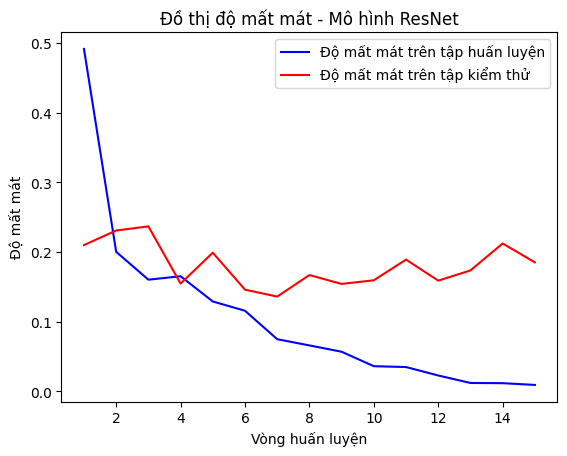

In [17]:
# Đồ thị hàm mất mát
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs = range(1, len(loss3)+1)
plt.plot(epochs, loss3, 'b', label = 'Độ mất mát trên tập huấn luyện')
plt.plot(epochs, val_loss3, 'r'
, label = 'Độ mất mát trên tập kiểm thử')
plt.title('Đồ thị độ mất mát - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ mất mát')
plt.legend()
plt.show()

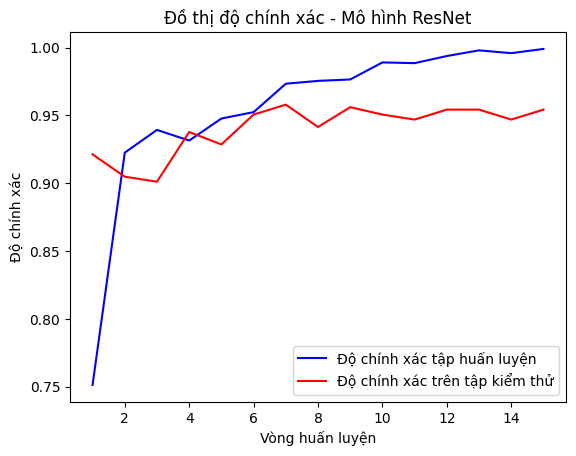

In [18]:
# Đồ thị độ chính xác của mô hình
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
plt.plot(epochs, acc3, 'b', label = 'Độ chính xác tập huấn luyện')
plt.plot(epochs, val_acc3, 'r', label = 'Độ chính xác trên tập kiểm thử')
plt.title('Đồ thị độ chính xác - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ chính xác')
plt.legend()
plt.show()

In [19]:
import numpy as np
from sklearn.metrics import f1_score

# Bước 1: Huấn luyện mô hình
# Bước 2: Dự đoán trên tập kiểm tra
y_pred_probs = model.predict(X_test_gray)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Bước 3: Tính toán F1-score
f1 = f1_score(y_test_gray, y_pred_classes, average='macro')
print(f"F1-score: {f1}")

18/18 [==============================] - 5s 295ms/step
F1-score: 0.9533790776229818


In [20]:
model.save('/content/drive/MyDrive/AI FINAL/CNN_GRAY.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
